In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# VAE Class

In [2]:
class VAE:
    def __init__(self, input_dim, hidden_dims, latent_dim, data_size=1):
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim

        # Encoder weights and biases
        self.encoder_weights = []
        self.encoder_biases = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            # self.encoder_weights.append(np.random.randn(prev_dim, h_dim) * 0.01)
            self.encoder_weights.append(np.random.randn(prev_dim, h_dim) * 0.01)
            self.encoder_biases.append(np.zeros((1, h_dim)))
            prev_dim = h_dim

        # Latent space parameters
        # self.W_mu = np.random.randn(prev_dim, latent_dim) * 0.01
        self.W_mu = np.random.randn(prev_dim, latent_dim) * 0.01
        self.b_mu = np.zeros((1, latent_dim))
        # self.W_logvar = np.random.randn(prev_dim, latent_dim) * 0.01
        self.W_logvar = np.random.randn(prev_dim, latent_dim) * 0.01
        self.b_logvar = np.zeros((1, latent_dim))

        # Decoder weights and biases
        self.decoder_weights = []
        self.decoder_biases = []
        hidden_dims_reverse = list(reversed(hidden_dims))
        prev_dim = latent_dim
        for h_dim in hidden_dims_reverse:
            # self.decoder_weights.append(np.random.randn(prev_dim, h_dim) * 0.01)
            self.decoder_weights.append(np.random.randn(prev_dim, h_dim) * 0.01)
            self.decoder_biases.append(np.zeros((1, h_dim)))
            prev_dim = h_dim

        # Final decoder layer
        self.W_out = np.random.randn(prev_dim, input_dim) * 0.01
        self.b_out = np.zeros((1, input_dim))

    # Activation functions
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self,x):
        s = self.sigmoid(x)
        return s * (1 - s)

    def softplus(self,x):
        return np.log10(1 + np.exp(x))

    def softplus_derivative(self,x):
        return 1 / (1 + np.exp(-x))

    def relu(self,x):
        return np.maximum(0, x)

    def relu_derivative(self,x):
        return (x > 0).astype(float)

    # Loss functions
    def binary_cross_entropy(self,y_pred, y_true):
        return -np.sum(y_true * np.log(y_pred ) + (1 - y_true) * np.log(1 - y_pred))

    def binary_cross_entropy_derivative(self,y_pred, y_true):
        # return (y_pred - y_true) / (y_pred * (1 - y_pred))
        return -y_true /y_pred + (1-y_true)/(1-y_pred)

    def kl_divergence(self,mu, logvar):
        return -0.5 * np.sum(1 + logvar - np.square(mu) - (logvar))

    # Reparameterization trick
    def reparameterize(self,mu, logvar):
        std = np.exp(0.5 * logvar)
        self.eps = np.random.randn(*mu.shape)
        return mu + self.eps * std

    def forward(self, x):
        # Encoder forward pass
        h = x
        encoder_activations = []
        for W, b in zip(self.encoder_weights, self.encoder_biases):
            h = self.relu(np.dot(h, W) + b)
            encoder_activations.append(h)
        if not encoder_activations:
            encoder_activations.append(h)

        # Latent space
        mu = np.dot(h, self.W_mu) + self.b_mu
        logvar = np.dot(h, self.W_logvar) + self.b_logvar
        z = self.reparameterize(mu, self.relu(logvar))

        # Decoder forward pass
        h = z
        decoder_activations = []
        # print(self.decoder_weights, self.decoder_biases)
        for W, b in zip(self.decoder_weights, self.decoder_biases):
            h = self.relu(np.dot(h, W) + b)
            decoder_activations.append(h)
        if not decoder_activations:
            decoder_activations.append(h)
        x_recon = self.sigmoid(np.dot(h, self.W_out) + self.b_out)

        return x_recon, mu, logvar, z, encoder_activations, decoder_activations

    def only_forward(self,x,w_enc, b_enc,w_mu,b_mu, w_var, b_var, w_dec, b_dec):
        # Encoder forward pass
        h = x
        encoder_activations = []
        for W, b in zip(self.encoder_weights, self.encoder_biases):
            h = self.relu(np.dot(h, W) + b)
            encoder_activations.append(h)
        if not encoder_activations:
            encoder_activations.append(h)

        # Latent space
        mu = np.dot(h, self.W_mu) + self.b_mu
        logvar = np.dot(h, self.W_logvar) + self.b_logvar
        z = self.reparameterize(mu, self.relu(logvar))

        # Decoder forward pass
        h = z
        decoder_activations = []
        # print(self.decoder_weights, self.decoder_biases)
        for W, b in zip(self.decoder_weights, self.decoder_biases):
            h = self.relu(np.dot(h, W) + b)
            decoder_activations.append(h)
        if not decoder_activations:
            decoder_activations.append(h)
        x_recon = self.sigmoid(np.dot(h, self.W_out) + self.b_out)

        return x_recon, mu, logvar, z, encoder_activations, decoder_activations

    def backward(self, x, x_recon, mu, logvar, z, encoder_activations, decoder_activations, learning_rate):
        # Gradient of reconstruction loss with respect to x_recon
        d_x_recon = self.binary_cross_entropy_derivative(x_recon, x)

        # Backpropagate through the output layer
        d_h = d_x_recon * (x_recon * (1 - x_recon))  # Sigmoid derivative

        # Update final decoder layer
        self.W_out -= learning_rate * np.matmul(decoder_activations[-1].T, d_h)
        self.b_out -= learning_rate * np.sum(d_h, axis=0, keepdims=True)

        d_h = d_h = np.matmul(d_h, self.W_out.T)

        # Update decoder hidden layers
        for i in reversed(range(len(self.decoder_weights))):
            # d_h = np.dot(d_h, self.decoder_weights[i].T) * (decoder_activations[i] > 0).astype(float)  # ReLU derivative
            self.decoder_weights[i] -= learning_rate * np.matmul(decoder_activations[i - 1].T, d_h) if i > 0 else learning_rate * np.matmul(z.T, d_h)
            self.decoder_biases[i] -= learning_rate * np.sum(d_h, axis=0, keepdims=True)
            d_h = np.matmul(d_h, self.decoder_weights[i].T) * self.relu_derivative(decoder_activations[i-1]) if i>0 else np.matmul(d_h, self.decoder_weights[i].T)

        # Gradients for latent space
        # d_z = np.dot(d_h, self.decoder_weights[0].T)  # Backprop into latent space

        # Backpropagate through the reparameterization trick
        d_mu = d_h
        d_logvar = 0.5 * d_h * self.eps * np.exp(0.5 * logvar)

        # Update latent space weights and biases
        self.W_mu -= learning_rate * np.matmul(encoder_activations[-1].T, d_mu)
        self.b_mu -= learning_rate * np.sum(d_mu, axis=0, keepdims=True)

        self.W_logvar -= learning_rate * np.matmul(encoder_activations[-1].T, d_logvar)
        self.b_logvar -= learning_rate * np.sum(d_logvar, axis=0, keepdims=True)

        # self.W_mu -= learning_rate * (np.dot(encoder_activations[-1].T, d_h) + np.dot(encoder_activations[-1].T, mu))
        # grad_b_mu = (np.sum(d_h, axis=1, keepdims=True) + mu)
        # for mu_elem in grad_b_mu:
        #     self.b_mu -= learning_rate * mu_elem

        # self.W_logvar -= learning_rate * np.dot(encoder_activations[-1].T,(0.5 * d_h * self.eps * np.exp(0.5 * logvar)))
        # self.b_logvar -= learning_rate * (np.sum(0.5 * d_h * self.eps * np.exp(0.5 * logvar), axis=0, keepdims=True))

        # d_mu = d_h + mu
        # d_logvar = 0.5 * d_h * self.eps * np.exp(0.5 * logvar) * self.relu_derivative(logvar)

        # Update encoder layers
        d_h = np.matmul(d_mu, self.W_mu.T) + np.matmul(d_logvar, self.W_logvar.T)
        for i in reversed(range(len(self.encoder_weights))):
            self.encoder_weights[i] -= learning_rate * np.matmul(encoder_activations[i - 1].T, d_h) if i > 0 else learning_rate * np.matmul(x.T, d_h)
            self.encoder_biases[i] -= learning_rate * np.sum(d_h, axis=0, keepdims=True)
            d_h = np.matmul(d_h, self.encoder_weights[i].T) * self.relu_derivative(encoder_activations[i-1]) if i>0 else np.matmul(d_h, self.encoder_weights[i].T)

    def train(self, x, valid_data, epochs, learning_rate, doTest = True):
        history_loss = []
        preTrain_data = x.copy()
        print(f'Data to train: {x}')
        print(f'Valid Data: {valid_data}')

        # if len(valid_data.shape) == 3:
        for epoch in range(epochs):
            total_loss = 0
            kl_loss = 0
            recon_loss = 0
            # for idx,sample in enumerate(x):  # Iterate through each column
            #     # print(f'Iter {idx}\tTraining of data {sample} based on data {valid_data[idx]}')
            #     curr_data = sample.reshape(1, -1)
            #     # print(f'Reshaped data: {curr_data}')
            #     x_recon, mu, logvar, z, encoder_activations, decoder_activations = self.forward(curr_data)
            #     # print(f'Current reconstruction: {x_recon}')

            #     # Compute losses
            #     recon_loss_sample = self.binary_cross_entropy(x_recon, valid_data[idx])
            #     kl_loss_sample = self.kl_divergence(mu, logvar)
            #     loss = recon_loss_sample + kl_loss_sample

            #     # Backward pass
            #     self.backward(valid_data[idx], x_recon, mu, logvar, z, encoder_activations, decoder_activations, learning_rate)

            #     # Accumulate losses
            #     total_loss += loss
            #     kl_loss += kl_loss_sample
            #     recon_loss += recon_loss_sample

            # print(f'Iter {idx}\tTraining of data {sample} based on data {valid_data[idx]}')
            curr_data = x.copy()
            # print(f'Reshaped data: {curr_data}')
            x_recon, mu, logvar, z, encoder_activations, decoder_activations = self.forward(curr_data)
            # print(f'Current reconstruction: {x_recon}')

            # Compute losses
            recon_loss_sample = self.binary_cross_entropy(x_recon, valid_data)
            kl_loss_sample = self.kl_divergence(mu, logvar)
            beta = 0.1
            loss = recon_loss_sample + beta * kl_loss_sample

            # Backward pass
            self.backward(valid_data, x_recon, mu, logvar, z, encoder_activations, decoder_activations, learning_rate)

            # Accumulate losses
            total_loss += loss
            kl_loss += kl_loss_sample
            recon_loss += recon_loss_sample

            # Loss history
            curr_avg_loss = total_loss/x.shape[0]
            history_loss.append(curr_avg_loss)

            # Check error and break
            if total_loss < (2**(-8)):
                break

            # Print epoch details
            if (epoch + 1) % 1 == 0 or epoch == 0:
                # print(f"Epoch {epoch + 1}/{epochs} - Total Loss: {total_loss:.4f}, Recon Loss: {recon_loss:.4f}, KL Loss: {kl_loss:.4f}, Average Loss: {curr_avg_loss:.4f}",end='\n')
                print(f"Epoch {epoch + 1}/{epochs} - Total Loss: {total_loss:.4f}, Recon Loss: {recon_loss:.4f}, KL Loss: {kl_loss:.4f}",end='\n')
        # else:
        #     for epoch in range(epochs):
        #         total_loss = 0
        #         kl_loss = 0
        #         recon_loss = 0
        #         for idx,sample in enumerate(x):  # Iterate through each column
        #             # print(f'Iter {idx}\tTraining of data {sample} based on data {valid_data[idx]}')
        #             curr_data = sample.reshape(1, -1)
        #             # print(f'Reshaped data: {x}')
        #             x_recon, mu, logvar, z, encoder_activations, decoder_activations = self.forward(curr_data)

        #             # Compute losses
        #             recon_loss_sample = self.binary_cross_entropy(x_recon, valid_data)
        #             kl_loss_sample = self.kl_divergence(mu, logvar)
        #             loss = recon_loss_sample + kl_loss_sample

        #             # Backward pass
        #             self.backward(valid_data, x_recon, mu, logvar, z, encoder_activations, decoder_activations, learning_rate)

        #             # Accumulate losses
        #             total_loss += loss
        #             kl_loss += kl_loss_sample
        #             recon_loss += recon_loss_sample

        #         # Loss history
        #         curr_avg_loss = total_loss/x.shape[0]
        #         history_loss.append(curr_avg_loss)

        #         # Check error and break
        #         if total_loss < (2**(-8)):
        #             break

        #         # Print epoch details
        #         if (epoch + 1) % 1 == 0 or epoch == 0:
        #             # print(f"Epoch {epoch + 1}/{epochs} - Total Loss: {total_loss:.4f}, Recon Loss: {recon_loss:.4f}, KL Loss: {kl_loss:.4f}, Average Loss: {curr_avg_loss:.4f}",end='\n')
        #             print(f"Epoch {epoch + 1}/{epochs} - Total Loss: {total_loss:.4f}, Recon Loss: {recon_loss:.4f}, KL Loss: {kl_loss:.4f}",end='\n')

        print(f'This Data: {x}')
        print(f'Has finished trained based on the following Valid Data:')
        check_valid_data = []
        for i in valid_data: print(i); check_valid_data.append(i)
        if doTest:
            # Evaluate: Reconstruct the input data
            reconstructed = []
            latent_val = []
            for x in preTrain_data:
                x = x.reshape(1, -1)
                x_recon, _, _, curr_latent, _, _ = self.forward(x)
                reconstructed.append(x_recon)
                latent_val.append(curr_latent)
            reconstructed = np.vstack(reconstructed)

            print(f"\nOriginal Data: (Shape: {preTrain_data.shape})")
            print(preTrain_data)

            print(f"\nReconstructed Data: (Shape: {reconstructed.shape})")
            print(np.round(reconstructed))  # Rounded for binary output

            # mtrx_true_data = np.tile(valid_data[0], (x.shape[0],1))
            # if ((np.round(reconstructed)==mtrx_true_data).all()): print('[INFO] Reconstruction success')
            # else: print('[ERROR] Reconstruction Failed')

            if ((np.round(reconstructed)==check_valid_data).all()): print('[INFO] Reconstruction success')
            else: print('[ERROR] Reconstruction Failed')

            plt.figure(figsize=(10,9))
            plt.plot(history_loss,label="Loss History")
            plt.legend()
            plt.xlabel("Epoch")
            plt.ylabel("Error")
            plt.title('Total History over Epochs')
            plt.show()

        # After training, return latent value
        return latent_val



    def get_train_param(self):
        return self.encoder_weights,self.encoder_biases, self.W_mu,self.b_mu, self.W_logvar,self.b_logvar, self.decoder_weights,self.decoder_biases, self.W_out, self.b_out

# Testing VAE on X and O data

Data to train: [[1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [0. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 0. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 0. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 0. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [0. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 1. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 1. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 0. 0. 1. 0. 1.]]
Valid Data: [[1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0. 1.]]
Epoch 1/1000 - Total Loss: 74.2422, Recon Loss: 74.8420, KL Loss: -5.9985
Epoch 2/1000 - Total Loss: 73.6178, Recon Loss: 74.2175, KL Loss: -5.9967
Epoch 3/1000 - Total Loss: 72.8430, Recon Loss: 73.4425, KL Loss: -5.9954
Epoch 4/1000 - Total Loss: 72

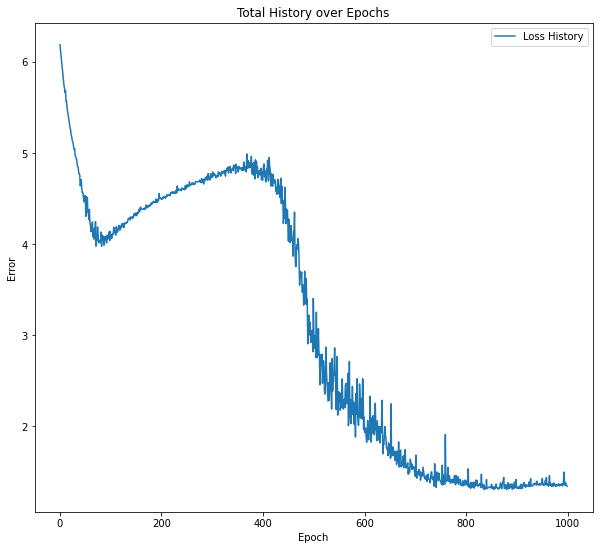

In [3]:
input_dim = 9  # Number of input features
latent_dim = 1  # Number of latent dimensions
hidden_dims = []

vae = VAE(input_dim=input_dim, hidden_dims=hidden_dims, latent_dim=latent_dim)

# Create dataset
testData = np.zeros((12,9))
testData[0,:] = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]]).reshape(1,9).flatten()
testData[1,:] = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 1]]).reshape(1,9).flatten()
testData[2,:] = np.array([[1, 0, 1], [1, 0, 1], [1, 1, 1]]).reshape(1,9).flatten()
testData[3,:] = np.array([[1, 1, 0], [1, 0, 1], [1, 1, 1]]).reshape(1,9).flatten()
testData[4,:] = np.array([[1, 1, 1], [0, 0, 1], [1, 1, 1]]).reshape(1,9).flatten()
testData[5,:] = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]]).reshape(1,9).flatten()

testData[6,:] = np.array([[1, 0, 1], [0, 1, 0], [1, 0, 1]]).reshape(1,9).flatten()
testData[7,:] = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 1]]).reshape(1,9).flatten()
testData[8,:] = np.array([[1, 1, 1], [0, 1, 0], [1, 0, 1]]).reshape(1,9).flatten()
testData[9,:] = np.array([[1, 0, 0], [0, 1, 0], [1, 0, 1]]).reshape(1,9).flatten()
testData[10,:] = np.array([[1, 0, 1], [1, 1, 0], [1, 0, 1]]).reshape(1,9).flatten()
testData[11,:] = np.array([[1, 0, 1], [0, 0, 0], [1, 0, 1]]).reshape(1,9).flatten()

valid_data = np.zeros((12,9))
valid_data[:6,:] = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]]).reshape(1,9).flatten()
valid_data[6:,:] = np.array([[1, 0, 1], [0, 1, 0], [1, 0, 1]]).reshape(1,9).flatten()

# data = testData

# label_train_simple = np.concatenate((valid_data1, valid_data2), axis=0)
# data_train_simple = np.concatenate((data, data), axis=0)

# Train the VAE
epochs = 1000
learning_rate = 0.005
latent_val = vae.train(testData, valid_data, epochs, learning_rate)

# Wafermap Data Learning

## Reading Dataset of Wafermap

In [4]:
import cv2
df=pd.read_pickle("WM811K.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   dieSize         811457 non-null  float64
 1   failureType     811457 non-null  object 
 2   lotName         811457 non-null  object 
 3   trainTestLabel  811457 non-null  object 
 4   waferIndex      811457 non-null  float64
 5   waferMap        811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


,dieSize,failureType,lotName,trainTestLabel,waferIndex,waferMap
0,1683.0,none,lot1,Training,1.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,1683.0,none,lot1,Training,2.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,1683.0,none,lot1,Training,3.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,1683.0,none,lot1,Training,4.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,1683.0,none,lot1,Training,5.0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [5]:
# Function to scale up image
def upscale_images(np_arr, max_shape):
    return cv2.resize(np_arr, (max_shape[1],max_shape[0]), interpolation=cv2.INTER_CUBIC)

def sizeLimit_df(old_df, max_shape, doLimit=False):
  if doLimit: return old_df[old_df['waferMap'].apply(lambda x: x.shape[0] <= max_shape[0] and x.shape[1] <= max_shape[1])]
  else: return old_df

# Function to display wafer
def print_image(np_arr):
    if np.max(np_arr) == 2: cmap = mcolors.ListedColormap(['black', 'grey', 'white'])
    else: cmap = mcolors.ListedColormap(['black', 'grey'])
    # Create an image of the array
    plt.imshow(np_arr, cmap=cmap, interpolation='nearest')

    # Optionally, remove axis labels
    plt.axis('off')

    # Show the plot
    plt.show()

## Get Training Data

In [70]:
max_shape = (40,40)
target_shape = (32,32)
train_max_row = 20 # Maximum data for training

strClass_trainTestLaebl_df = df[df['trainTestLabel'].apply(lambda x: isinstance(x, str))]
limited_df = sizeLimit_df(strClass_trainTestLaebl_df,max_shape,True)
training_df = limited_df[limited_df['trainTestLabel'] == 'Training']

bad_wafer_df = training_df[ (training_df['failureType'] != 'none')]
good_wafer_df = training_df[ (training_df['failureType'] == 'none')]

# Function to filter very bad data
def filter_condition(np_arr, wafer_type):
    count_0 = np.sum(np_arr == 0)  # Count occurrences of 1
    count_1 = np.sum(np_arr == 1)  # Count occurrences of 1
    count_2 = np.sum(np_arr == 2)  # Count occurrences of 2
    if wafer_type == 'bad': return (count_2 > 0.05 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1
    else: return (count_2 < 0.05 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1


bad_wafer_df = bad_wafer_df[bad_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'bad'))]
good_wafer_df = good_wafer_df[good_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'good'))]

# Label data for bad wafer
maxSize_bad_wafer = bad_wafer_df[(bad_wafer_df['waferMap'].apply(lambda x: x.shape == (35,36)))]
mtrx_label_bad_wafer = np.stack(maxSize_bad_wafer['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
mtrx_label_bad_wafer[(mtrx_label_bad_wafer == 1) | (mtrx_label_bad_wafer > 2)] = 2
base_bad_valid = np.array(mtrx_label_bad_wafer[0])
label_bad_wafer = np.tile(base_bad_valid,(train_max_row,1))

# Label data for good wafer
maxSize_good_wafer = good_wafer_df[(good_wafer_df['waferMap'].apply(lambda x: x.shape == (35,37)))]
mtrx_label_good_wafer = np.stack(maxSize_good_wafer['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
mtrx_label_good_wafer[mtrx_label_good_wafer >1] = 1
base_good_valid = np.array(mtrx_label_good_wafer[0])
label_good_wafer = np.tile(base_good_valid,(train_max_row,1))

# Maximum Data for Training
# print(bad_wafer_df.shape, good_wafer_df.shape)
max_training_good = good_wafer_df.shape[0]
max_training_bad = bad_wafer_df.shape[0]
print(max_training_good, max_training_bad)
bad_wafer_df = bad_wafer_df[:train_max_row]
good_wafer_df = good_wafer_df[:train_max_row]

# Scale all image to asme dimension then flatten it to single row
data_bad_wafer = np.stack(bad_wafer_df['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
data_bad_wafer[data_bad_wafer>2] = 2

data_good_wafer = np.stack(good_wafer_df['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
data_good_wafer[data_good_wafer>2] = 2

label_train = np.concatenate((label_bad_wafer, label_good_wafer), axis=0)
data_train = np.concatenate((data_bad_wafer, data_good_wafer), axis=0)

label_train = np.where(label_train == 0, 0 , np.where(label_train == 1, 0.5, 1))
data_train = np.where(data_train == 0, 0 , np.where(data_train == 1, 0.5, 1))

print(label_train.shape)
print(data_train.shape)


106 8003
(40, 1024)
(40, 1024)


In [71]:
# label_train = np.concatenate((label_good_wafer,label_bad_wafer), axis=0)
# data_train = np.concatenate((data_good_wafer, data_bad_wafer), axis=0)
label_train = np.concatenate((label_bad_wafer, label_good_wafer), axis=0)
data_train = np.concatenate((data_bad_wafer, data_good_wafer), axis=0)

label_train = np.where(label_train == 0, 0 , np.where(label_train == 1, 0.5, 1))
data_train = np.where(data_train == 0, 0 , np.where(data_train == 1, 0.5, 1))

print(label_train.shape)
print(data_train.shape)

(40, 1024)
(40, 1024)


#### Extra Testing

Unique Shapes (from smallest to largest):
Shape: (26, 26), Area: 676, Count: 20


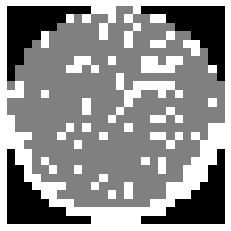

In [8]:
# Extract shapes and count occurrences
def filter_condition(np_arr):
    count_0 = np.sum(np_arr == 0)  # Count occurrences of 1
    count_1 = np.sum(np_arr == 1)  # Count occurrences of 1
    count_2 = np.sum(np_arr == 2)  # Count occurrences of 2
    return (count_2 > 0.05 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1
filtered_df = bad_wafer_df[bad_wafer_df['waferMap'].apply(filter_condition)]
# filtered_df = bad_wafer_df

shape_counts = filtered_df["waferMap"].apply(lambda img: img.shape).value_counts()

# Sort shapes sequentially (smallest to largest by area, then by dimensions)
sorted_shapes = sorted(shape_counts.items(), key=lambda x: (x[0][0] * x[0][1], x[0][0], x[0][1]))

# Print the unique shapes, their area, and counts
print("Unique Shapes (from smallest to largest):")
for shape, count in sorted_shapes:
    area = shape[0] * shape[1]
    print(f"Shape: {shape}, Area: {area}, Count: {count}")
    temp = bad_wafer_df[(bad_wafer_df['waferMap'].apply(lambda x: x.shape == shape))]
    print_image(temp['waferMap'].iloc[0])

Unique Shapes (from smallest to largest):
Shape: (39, 31), Area: 1209, Count: 1


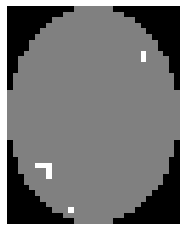

Shape: (35, 37), Area: 1295, Count: 19


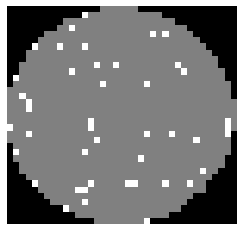

In [9]:
# Extract shapes and count occurrences
def filter_condition(np_arr):
    count_0 = np.sum(np_arr == 0)  # Count occurrences of 1
    count_1 = np.sum(np_arr == 1)  # Count occurrences of 1
    count_2 = np.sum(np_arr == 2)  # Count occurrences of 2
    return (count_2 < 0.05 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1
filtered_df = good_wafer_df[good_wafer_df['waferMap'].apply(filter_condition)]

shape_counts = filtered_df["waferMap"].apply(lambda img: img.shape).value_counts()

# Sort shapes sequentially (smallest to largest by area, then by dimensions)
sorted_shapes = sorted(shape_counts.items(), key=lambda x: (x[0][0] * x[0][1], x[0][0], x[0][1]))

# Print the unique shapes, their area, and counts
print("Unique Shapes (from smallest to largest):")
for shape, count in sorted_shapes:
    area = shape[0] * shape[1]
    print(f"Shape: {shape}, Area: {area}, Count: {count}")
    temp = good_wafer_df[(good_wafer_df['waferMap'].apply(lambda x: x.shape == shape))]
    print_image(temp['waferMap'].iloc[0])

## Train Good and Bad Wafer Data

In [72]:
# Initialize the VAE with no hidden layers
input_dim = data_train.shape[1]  # Number of input features
latent_dim = 1  # Number of latent dimensions
hidden_dims = []

vae = VAE(input_dim=input_dim, hidden_dims=hidden_dims, latent_dim=latent_dim)

max_shape = (40,40)
target_shape = (32,32)
train_max_row = 20 # Maximum data for training

strClass_trainTestLaebl_df = df[df['trainTestLabel'].apply(lambda x: isinstance(x, str))]
limited_df = sizeLimit_df(strClass_trainTestLaebl_df,max_shape,True)
training_df = limited_df[limited_df['trainTestLabel'] == 'Training']

bad_wafer_df = training_df[ (training_df['failureType'] != 'none')]
good_wafer_df = training_df[ (training_df['failureType'] == 'none')]

# Function to filter very bad data
def filter_condition(np_arr, wafer_type):
    count_0 = np.sum(np_arr == 0)  # Count occurrences of 1
    count_1 = np.sum(np_arr == 1)  # Count occurrences of 1
    count_2 = np.sum(np_arr == 2)  # Count occurrences of 2
    if wafer_type == 'bad': return (count_2 > 0.9 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1
    else: return (count_2 < 0.05 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1
    # return True


bad_wafer_df = bad_wafer_df[bad_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'bad'))]
good_wafer_df = good_wafer_df[good_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'good'))]
print(bad_wafer_df.shape, good_wafer_df.shape)

# Label data for bad wafer
maxSize_bad_wafer = bad_wafer_df[(bad_wafer_df['waferMap'].apply(lambda x: x.shape == (35,36)))]
mtrx_label_bad_wafer = np.stack(maxSize_bad_wafer['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
mtrx_label_bad_wafer[(mtrx_label_bad_wafer == 1) | (mtrx_label_bad_wafer > 2)] = 2
base_bad_valid = np.array(mtrx_label_bad_wafer[0])


# Label data for good wafer
maxSize_good_wafer = good_wafer_df[(good_wafer_df['waferMap'].apply(lambda x: x.shape == (35,37)))]
mtrx_label_good_wafer = np.stack(maxSize_good_wafer['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
mtrx_label_good_wafer[mtrx_label_good_wafer >1] = 1
base_good_valid = np.array(mtrx_label_good_wafer[0])

(245, 6) (106, 6)


Data to train: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Valid Data: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Epoch 1/200 - Total Loss: 29809.3808, Recon Loss: 29811.4613, KL Loss: -20.8050
Epoch 2/200 - Total Loss: 29790.4941, Recon Loss: 29792.5425, KL Loss: -20.4842
Epoch 3/200 - Total Loss: 29769.3754, Recon Loss: 29771.1988, KL Loss: -18.2333
Epoch 4/200 - Total Loss: 29735.2025, Recon Loss: 29735.2856, KL Loss: -0.8310
Epoch 5/200 - Total Loss: 29649.8709, Recon Loss: 29639.5042, KL Loss: 103.6677
Epoch 6/200 - Total Loss: 29308.8837, Recon Loss: 29246.3589, KL Loss: 625.2482
Epoch 7/200 - Total Loss: 27782.7573, Recon Loss: 27471.0846, KL Loss: 3116.7270
Epoch 8/200 - Total Loss: 23238.4012, Recon Loss: 21938.6084, KL Loss: 12997.9285
Epoch 9/200 - Total

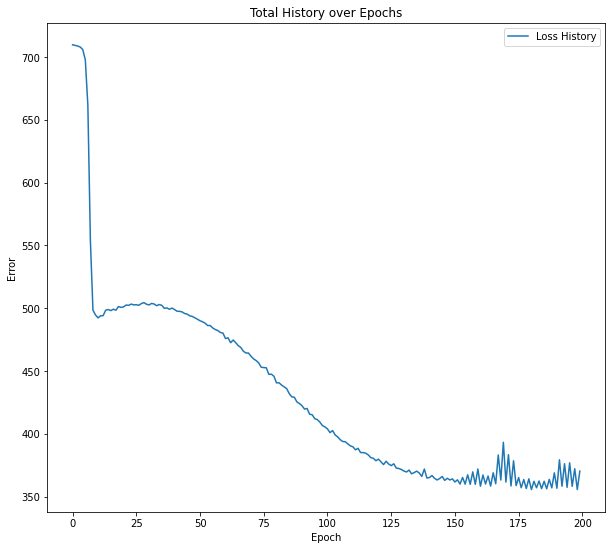

42
[array([[32.81075581]]), array([[34.47137067]]), array([[34.1778934]]), array([[37.97701273]]), array([[29.22557259]]), array([[33.92183907]]), array([[35.49878893]]), array([[32.00959348]]), array([[38.20713599]]), array([[37.76594335]]), array([[32.49083035]]), array([[34.3749907]]), array([[35.19294482]]), array([[35.27767364]]), array([[33.80811354]]), array([[39.02974343]]), array([[29.23285932]]), array([[28.86974605]]), array([[31.04110726]]), array([[27.75925822]]), array([[28.83087695]]), array([[12.18919469]]), array([[3.07164583]]), array([[3.46629381]]), array([[3.89539146]]), array([[4.15515066]]), array([[4.86767253]]), array([[4.39550702]]), array([[4.75622875]]), array([[5.06656136]]), array([[4.14024195]]), array([[4.30049285]]), array([[6.13239676]]), array([[3.83745335]]), array([[5.50536621]]), array([[6.28737482]]), array([[4.84136228]]), array([[4.11010348]]), array([[5.76534981]]), array([[6.44920756]]), array([[5.21871832]]), array([[5.28883352]])]
Data to tr

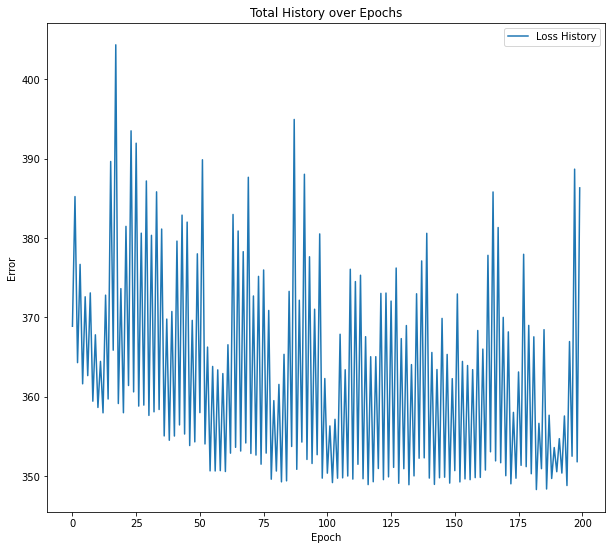

42
[array([[31.46578648]]), array([[38.562344]]), array([[29.32680087]]), array([[40.18743651]]), array([[38.01696302]]), array([[37.92966711]]), array([[42.02235105]]), array([[42.19547571]]), array([[40.62851299]]), array([[40.14510364]]), array([[39.73280914]]), array([[45.4799863]]), array([[44.06054397]]), array([[48.7827236]]), array([[35.05207834]]), array([[45.40596725]]), array([[47.08851387]]), array([[46.03130128]]), array([[46.68958177]]), array([[33.07153449]]), array([[30.72175652]]), array([[3.40180678]]), array([[5.4268554]]), array([[3.04668846]]), array([[4.82274773]]), array([[3.18058737]]), array([[5.57260753]]), array([[4.51418137]]), array([[3.88567237]]), array([[5.1054121]]), array([[5.27965595]]), array([[4.69656841]]), array([[3.32697345]]), array([[2.77245467]]), array([[2.24077927]]), array([[7.33743736]]), array([[4.53112813]]), array([[3.38531106]]), array([[3.79612528]]), array([[6.34651087]]), array([[1.96140984]]), array([[4.47843855]])]
Data to train: 

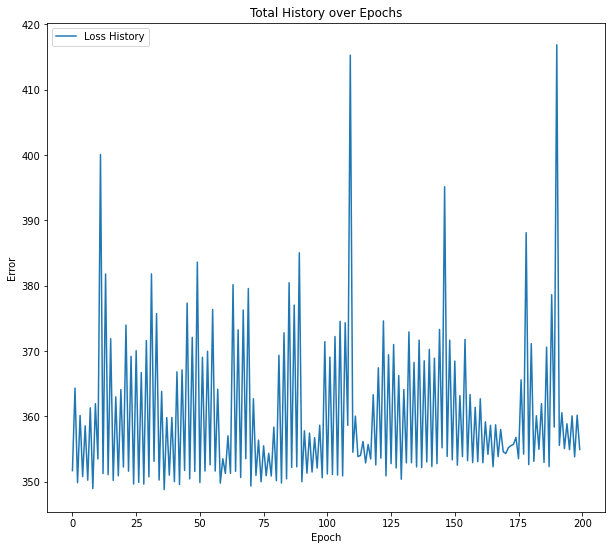

42
[array([[41.41897653]]), array([[38.98445758]]), array([[42.86553692]]), array([[49.29782393]]), array([[52.31321736]]), array([[53.81880452]]), array([[31.86964624]]), array([[54.84057477]]), array([[50.17865023]]), array([[56.47752691]]), array([[44.34725568]]), array([[45.026284]]), array([[52.28868868]]), array([[53.81753075]]), array([[47.85226405]]), array([[49.94216577]]), array([[49.8979568]]), array([[54.87237919]]), array([[55.16431522]]), array([[47.7902724]]), array([[50.54005404]]), array([[4.69218664]]), array([[7.03882657]]), array([[6.0491659]]), array([[6.97508599]]), array([[5.02521382]]), array([[5.02911489]]), array([[5.80221765]]), array([[6.28896231]]), array([[4.61485718]]), array([[6.98834255]]), array([[7.17150544]]), array([[5.94795277]]), array([[7.42545012]]), array([[7.40034254]]), array([[4.21999698]]), array([[5.84948649]]), array([[7.60787767]]), array([[7.03616551]]), array([[3.33454639]]), array([[5.21874065]]), array([[6.44187677]])]
Data to train:

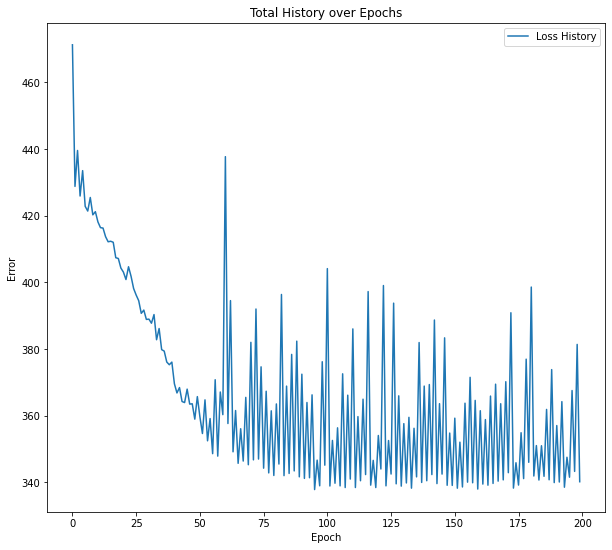

42
[array([[56.5915688]]), array([[48.23698248]]), array([[39.50405162]]), array([[44.90093418]]), array([[45.23222617]]), array([[44.78122084]]), array([[48.95777582]]), array([[41.19007112]]), array([[44.61716882]]), array([[42.30991818]]), array([[44.77906173]]), array([[43.11553758]]), array([[41.24690216]]), array([[45.09891301]]), array([[48.50052083]]), array([[45.53695273]]), array([[43.37025206]]), array([[42.74276036]]), array([[40.26228762]]), array([[42.66978187]]), array([[48.03668114]]), array([[9.75775748]]), array([[9.14986987]]), array([[8.64358366]]), array([[9.38768179]]), array([[8.27423094]]), array([[6.73971548]]), array([[8.27502742]]), array([[6.91568488]]), array([[8.74956431]]), array([[9.41974312]]), array([[8.18824404]]), array([[7.23728628]]), array([[6.85832589]]), array([[9.47224506]]), array([[8.84977833]]), array([[8.47480845]]), array([[7.69893511]]), array([[6.4098991]]), array([[8.54133754]]), array([[6.72639983]]), array([[7.59163033]])]
Data to tra

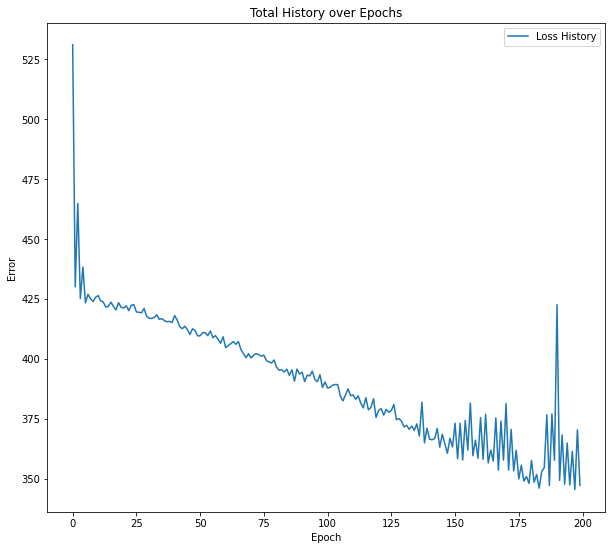

42
[array([[49.53196353]]), array([[44.18671998]]), array([[47.26681765]]), array([[41.3099941]]), array([[45.79929726]]), array([[41.40124025]]), array([[39.69869398]]), array([[38.89725981]]), array([[37.43353451]]), array([[41.83293046]]), array([[41.63486768]]), array([[40.40194972]]), array([[27.25236076]]), array([[24.01678428]]), array([[34.90201175]]), array([[44.71067387]]), array([[44.08288964]]), array([[34.74210129]]), array([[37.73171736]]), array([[37.62168424]]), array([[40.08853831]]), array([[10.17516391]]), array([[8.61801581]]), array([[6.64821853]]), array([[8.23807118]]), array([[8.26240106]]), array([[8.74207194]]), array([[14.72436668]]), array([[15.36659459]]), array([[16.36713711]]), array([[8.20084286]]), array([[10.52971982]]), array([[11.89054592]]), array([[11.30315105]]), array([[11.50016415]]), array([[11.77592811]]), array([[15.56890952]]), array([[11.19299391]]), array([[12.46133399]]), array([[11.71271556]]), array([[7.83619313]]), array([[8.09781966]]

In [73]:
# Train the VAE
epochs = 200
learning_rate = 0.0001
# print(data_good_wafer.shape)
# print(label_good_wafer.shape)

latent_val_good = []
latent_val_bad = []

for i in range(5):
    good_training_step = 21
    bad_training_step = 21

    bad_wafer_df = training_df[ (training_df['failureType'] != 'none')]
    good_wafer_df = training_df[ (training_df['failureType'] == 'none')]
    bad_wafer_df = bad_wafer_df[bad_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'bad'))]
    good_wafer_df = good_wafer_df[good_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'good'))]

    # Label data for bad wafer
    label_bad_wafer = np.tile(base_bad_valid,(bad_training_step,1))

    # Label data for good wafer
    label_good_wafer = np.tile(base_good_valid,(good_training_step,1))

    bad_wafer_df = bad_wafer_df[bad_training_step*i:bad_training_step * (i+1)] 
    good_wafer_df = good_wafer_df[good_training_step*i:good_training_step * (i+1)]

    # Scale all image to asme dimension then flatten it to single row
    data_bad_wafer = np.stack(bad_wafer_df['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
    data_bad_wafer[data_bad_wafer>2] = 2

    data_good_wafer = np.stack(good_wafer_df['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
    data_good_wafer[data_good_wafer>2] = 2

    label_train = np.concatenate((label_bad_wafer, label_good_wafer), axis=0)
    data_train = np.concatenate((data_bad_wafer, data_good_wafer), axis=0)

    label_train = np.where(label_train == 0, 0 , np.where(label_train == 1, 0.5, 1))
    data_train = np.where(data_train == 0, 0 , np.where(data_train == 1, 0.5, 1))
    
    curr_val_latent = vae.train(data_train, label_train, epochs, learning_rate)
    print(len(curr_val_latent))
    print(curr_val_latent)
    latent_val_bad.append(curr_val_latent[:bad_training_step])
    latent_val_good.append(curr_val_latent[bad_training_step:])

### Visualizing Latent Values

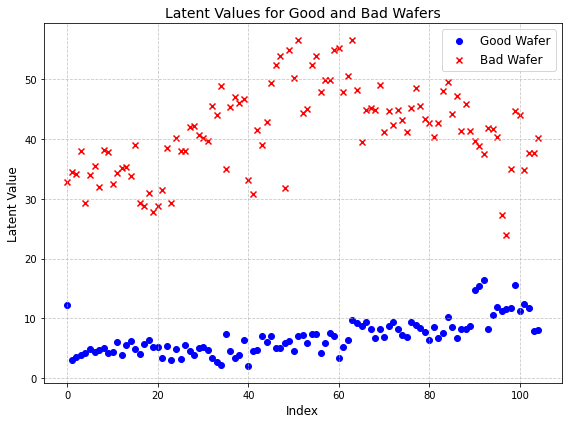

In [74]:
latent_bad_wafer = np.concatenate([np.concatenate(sublist).flatten() for sublist in latent_val_bad])
latent_good_wafer = np.concatenate([np.concatenate(sublist).flatten() for sublist in latent_val_good])

def plot_latent(good_latent,bad_latent):
    plt.figure(figsize=(8, 6))

    # Plot good wafers with 'o'
    plt.scatter(range(len(good_latent)), good_latent, marker='o', color='blue', label='Good Wafer')

    # Plot bad wafers with 'x'
    plt.scatter(range(len(bad_latent)), bad_latent, marker='x', color='red', label='Bad Wafer')

    # Adding labels, legend, and title
    plt.xlabel("Index", fontsize=12)
    plt.ylabel("Latent Value", fontsize=12)
    plt.title("Latent Values for Good and Bad Wafers", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Display the plot
    plt.tight_layout()
    plt.show()

plot_latent(latent_good_wafer,latent_bad_wafer)

#### Get Params

In [75]:
param_W_enc, param_B_enc, param_W_mu, param_B_mu, param_W_var, param_B_var, param_W_dec, param_B_dec, param_W_out, param_B_out = vae.get_train_param()

(2048, 1)


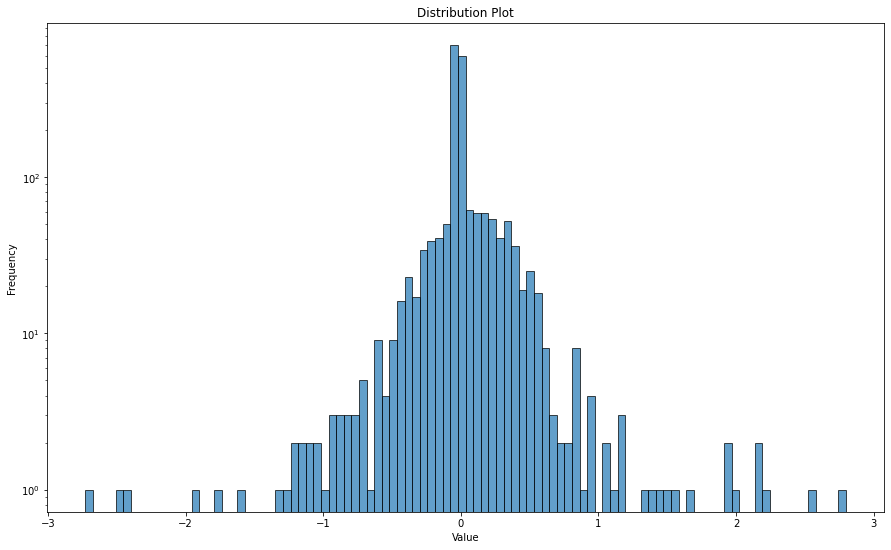

In [76]:
all_weight = np.concatenate((param_W_mu,param_W_var))
print(all_weight.shape)
# Create the distribution plot
plt.figure(figsize=(15,9))
plt.hist(all_weight, bins=100, edgecolor='black', alpha=0.7,log=True)  # Adjust the number of bins as needed

# Label axes
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution Plot')
# Show the plot
plt.show()

### Export Weight, Bias, and Input to txt

#### Float to Fixed Point and Vice versa Converters

In [77]:
def float_to_fp(value, total_bits=16, frac_bits=8, output_format='hex'):
    # Step 1: Check if the value is negative
    if value < 0:
        is_negative = True
        value = -value  # Work with the positive equivalent for conversion
    else:
        is_negative = False

    # Step 2: Multiply the float by 2^frac_bits to scale it
    scaled_value = round(value * (2 ** frac_bits))
    
    # Step 3: Convert the scaled value to a binary string
    # Format the binary string to the required total bits length
    binary_value = bin(scaled_value)[2:].zfill(total_bits)
    # print(f'Scaled Value: {scaled_value}')
    # print(f'Binary Value: {binary_value}')

    # Step 4: Handle the negative case
    if is_negative:
        # Perform two's complement conversion for negative numbers
        # Subtract the binary value from the max value for two's complement
        max_value = (1 << total_bits)  # This is 2^total_bits
        binary_value = bin(max_value - scaled_value)[2:].zfill(total_bits)
        neg_bit_length = len(binary_value)
        if neg_bit_length > total_bits: binary_value = binary_value[neg_bit_length-total_bits:]

    # Step 5: Convert the binary value to hexadecimal
    hex_value = hex(int(binary_value, 2))[2:].zfill(total_bits // 4)  # Convert to hex and remove '0x'

    # Step 6: Format output based on the `output_format` argument
    if output_format == 'binary':
        return binary_value
    elif output_format == 'hex':
        return hex_value
    elif output_format == 'both':
        return (f"{total_bits}'b{binary_value}", f"{total_bits}'h{hex_value}")
    else:
        raise ValueError("Invalid output format. Choose 'binary', 'hex', or 'both'.")
    
def fp_to_float(value,total_bits=16, frac_bits=8, input_format='hex'):
    if input_format == 'binary': fp_val = int(value,2)
    elif input_format == 'hex': fp_val = int(value,16)
    else: raise ValueError("Invalid input format. Must be 'binary' or 'hex'")
    # Calculate the scaling factor: 2^frac_width
    scaling_factor = 2 ** frac_bits
    # Handle two's complement if the sign bit is set (for negative numbers)
    sign_bit_mask = 1 << (total_bits - 1)  # Mask to isolate the sign bit
    
    # Check if the value is negative by examining the sign bit
    if fp_val & sign_bit_mask:  # If sign bit is 1, it's negative
        # Convert from two's complement
        fp_val = fp_val - (1 << total_bits)  # Apply the two's complement adjustment
    
    # Convert to float by dividing by the scaling factor
    float_value = fp_val / scaling_factor
    
    return float_value

# Example usage:
value = 64  # Example float number

num1 = float_to_fp(value)
inv_num1 = fp_to_float(str(num1))
print(num1,inv_num1)

4000 64.0


#### Exporting Weight and Bias to txt

In [78]:
def wr_to_file(np_arr,filename):
    with open(filename, 'w') as f:
        for val in np_arr:
            data = float_to_fp(val[0])
            f.write(data + '\n')

wr_to_file(param_W_mu,"data_tb\\weight_mu.txt")
wr_to_file(param_W_var,"data_tb\\weight_var.txt")
wr_to_file(param_B_mu, "data_tb\\bias_mu.txt")
wr_to_file(param_B_var, "data_tb\\bias_var.txt")

#### Exporting Input to txt

In [81]:
print(len(data_train))

42


In [ ]:
# export as 2 bit

data_train[0]

print(float_to_fp(0,total_bits=2,frac_bits=1,output_format='binary'))


def image_data_txt(np_arr, fn1, fn2, fn3, fn4):
    f1 = open(fn1,'w'); f2 = open(fn2, 'w')
    f3 = open(fn3,'w'); f4 = open(fn4, 'w')

    for idx in range(len(data_train[0])//(32*4)):
        data1 = []; data2 = []; data3 = []; data4 = [];
        idx1 = idx * 128
        idx2 = 32+ idx1
        idx3 = 32+ idx2
        idx4 = 32+ idx3
        fin_idx = 32 + idx4
        
        for i in range(idx2-1,idx1-1,-1): data1.append(float_to_fp(np_arr[i],total_bits=2,frac_bits=1))
        for i in range(idx3-1,idx2-1,-1): data2.append(float_to_fp(np_arr[i],total_bits=2,frac_bits=1))
        for i in range(idx4-1,idx3-1,-1): data3.append(float_to_fp(np_arr[i],total_bits=2,frac_bits=1))
        for i in range(fin_idx-1,idx4-1,-1): data4.append(float_to_fp(np_arr[i],total_bits=2,frac_bits=1))

        f1.write(''.join(data1) + '\n')
        f2.write(''.join(data2) + '\n')
        f3.write(''.join(data3) + '\n')
        f4.write(''.join(data4) + '\n')

    f1.close(); f2.close(); f3.close(); f4.close()

fn1 = "data_tb\\input_bad1.txt"
fn2 = "data_tb\\input_bad2.txt"
fn3 = "data_tb\\input_bad3.txt"
fn4 = "data_tb\\input_bad4.txt"

np_arr = data_train[0]
image_data_txt(np_arr, fn1, fn2, fn3, fn4)

00
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5
0.5
0.5
0.5
0.5
0.5
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5
0.5
0.5
0.5
0.5
0.5
0.5
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.5
0.5
0.5
0.5
0.5
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5
0.5
0.5
0.5
0.5
0.5
0.5
1.0
0.5
1.0
1.0
0.5
1.0
1.0
1.0
1.0
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
1.0
1.0
1.0
0.5
1.0
0.5
0.5
0.5
0.5
1.0
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.0
0.0
0.0
0.0
0.5
0.5
0.5
0.5
0.5
1.0
1.0
0.5
0.5
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.5
0.5
0.5
0.5
0.0
0.0
0.0
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.5
0.5
0.5
1.0
1.0
0.5
0.5
0.5
0.5
0.0
0.0
0.5
0.5
0.5
0.5
0.5
0.5
0.5
0.5
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.5
0.5
0.5
1

### Confusion Matrix

Threshold Range: 0.9804099345194572 to 12.802102849581411

Confusion Matrix:
                                         Actual Good Wafer    Actual Bad Wafer    
Predicted Good Wafer                     101                  0                   
Predicted Bad Wafer                      4                    105                 


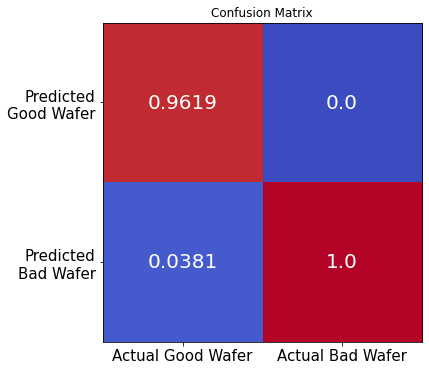

In [79]:
# latent_good_wafer = latent_val[train_max_row:]
# latent_bad_wafer = latent_val[:train_max_row]
# Compute mean and std for good wafer latent values
good_mean = np.mean(latent_good_wafer)
good_std = np.std(latent_good_wafer)

# Define thresholds
threshold_lower = good_mean - 2 * good_std
threshold_upper = good_mean + 2 * good_std

print(f"Threshold Range: {threshold_lower} to {threshold_upper}")

# Classify each latent value
def classify(np_arr, low_threshold, up_threshold):
    good_elems = np.sum((np_arr >= low_threshold) & (np_arr <= up_threshold))
    return good_elems, len(np_arr)-good_elems

bad_wafer_good_detection, bad_wafer_bad_detection = classify(latent_bad_wafer, threshold_lower, threshold_upper)
good_wafer_good_detection, good_wafer_bad_detection = classify(latent_good_wafer, threshold_lower, threshold_upper)

total_bad_testing_data = len(latent_bad_wafer)
total_good_testing_data = len(latent_good_wafer)

table = np.array([
    ["",    "Actual Good Wafer", "Actual Bad Wafer"],
    ["Predicted Good Wafer", good_wafer_good_detection, bad_wafer_good_detection],
    ["Predicted Bad Wafer", good_wafer_bad_detection, bad_wafer_bad_detection]
])

# Display the table
print("\nConfusion Matrix:")
print("{:<40} {:<20} {:<20}".format(*table[0]))  # Header row
for row in table[1:]:
    print("{:<40} {:<20} {:<20}".format(*row))  # Data rows

confusion_matrix = np.array([
    [np.round(good_wafer_good_detection/total_good_testing_data,4), np.round(bad_wafer_good_detection/total_bad_testing_data,4)],  # Predicted Good: Actual Good, Actual Bad
    [np.round(good_wafer_bad_detection/total_good_testing_data,4), np.round(bad_wafer_bad_detection/total_bad_testing_data,4)]   # Predicted Bad: Actual Good, Actual Bad
])

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(confusion_matrix, cmap="coolwarm")

# Adding labels
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(["Actual Good Wafer", "Actual Bad Wafer"], fontsize=15)
ax.set_yticklabels(["Predicted\nGood Wafer", "Predicted\nBad Wafer"], fontsize=15)

# Rotating tick labels for better readability
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Adding text annotations with text wrapping
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(confusion_matrix[i, j]), ha="center", va="center", color="white", fontsize=20)

# Title and display
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

## Testing to More Data

### Extract Data Testing

In [20]:
max_shape = (40,40)
target_shape = (30,30)
strClass_trainTestLaebl_df = df[df['trainTestLabel'].apply(lambda x: isinstance(x, str))]
limited_df = sizeLimit_df(strClass_trainTestLaebl_df,max_shape,True)
testing_df = limited_df[(limited_df['trainTestLabel'] == 'Training') | (limited_df['trainTestLabel'] == 'Test')]
# testing_df = limited_df[(limited_df['trainTestLabel'] == 'Training') ]

actual_bad_wafer_df = testing_df[(testing_df['failureType'] != 'none')]
actual_good_wafer_df = testing_df[(testing_df['failureType'] == 'none')]

# Function to filter very bad data
def filter_condition(np_arr, wafer_type):
    count_0 = np.sum(np_arr == 0)  # Count occurrences of 1
    count_1 = np.sum(np_arr == 1)  # Count occurrences of 1
    count_2 = np.sum(np_arr == 2)  # Count occurrences of 2
    if wafer_type == 'bad': return (count_2 > 1.5 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1
    else: return (count_2 < 0.05 * count_1) & (count_0 < count_1)  # Check if count of 2 is less than 20% of count of 1

actual_bad_wafer_df = actual_bad_wafer_df[actual_bad_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'bad'))]
actual_good_wafer_df = actual_good_wafer_df[actual_good_wafer_df['waferMap'].apply(lambda x: filter_condition(x, 'good'))]

# Get numpy array of actual data
actual_bad_wafer_data = np.stack(actual_bad_wafer_df['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())
actual_good_wafer_data = np.stack(actual_good_wafer_df['waferMap'].apply(lambda x: upscale_images(x, target_shape).flatten()).to_numpy())

actual_bad_wafer_data = actual_bad_wafer_data[:]
actual_good_wafer_data = actual_good_wafer_data[:]

# Prevent data more than 2
actual_bad_wafer_data[actual_bad_wafer_data>2] = 2
actual_good_wafer_data[actual_good_wafer_data>2] = 2

# Rescale data to 0 to 1
actual_bad_wafer_data = np.where(actual_bad_wafer_data == 0, 0 , np.where(actual_bad_wafer_data == 1, 0.5, 1))
actual_good_wafer_data = np.where(actual_good_wafer_data == 0, 0 , np.where(actual_good_wafer_data == 1, 0.5, 1))

print(actual_bad_wafer_data.shape)
print(actual_good_wafer_data.shape)

(103, 900)
(3401, 900)


### Input Data to Model and Visualize Scatter

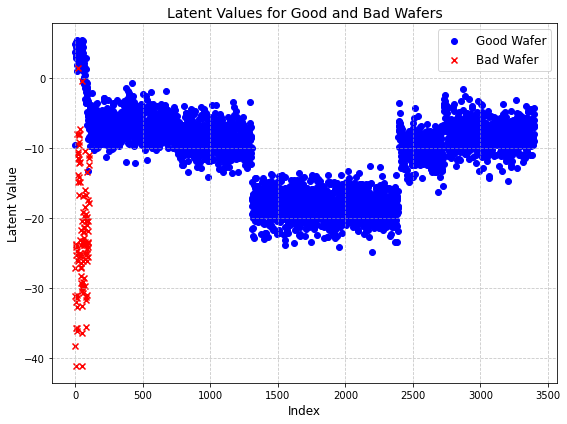

In [21]:
# Testing bad wafer data
def test_data(data_to_test):
    tested_latent_val = []
    for x in data_to_test:
        x = x.reshape(1, -1)
        _, _, _, curr_latent_val, _, _ = vae.forward(x)
        tested_latent_val.append(curr_latent_val)
    return tested_latent_val

latent_predicted_bad_wafer_data = test_data(actual_bad_wafer_data)
latent_predicted_good_wafer_data = test_data(actual_good_wafer_data)

# Compute mean and std for good wafer latent values
good_mean = np.mean(latent_predicted_good_wafer_data)
good_std = np.std(latent_predicted_good_wafer_data)

# Define thresholds
threshold_lower = good_mean - 2 * good_std
threshold_upper = good_mean + 2 * good_std

# Plot latent values
plot_latent(latent_predicted_good_wafer_data, latent_predicted_bad_wafer_data)

### Confusion Matrix of More Data Testing

Threshold Range: -22.33923280354101 to 0.0493880870345027

Confusion Matrix:
                                         Actual Good Wafer    Actual Bad Wafer    
Predicted Good Wafer                     3304                 43                  
Predicted Bad Wafer                      97                   60                  


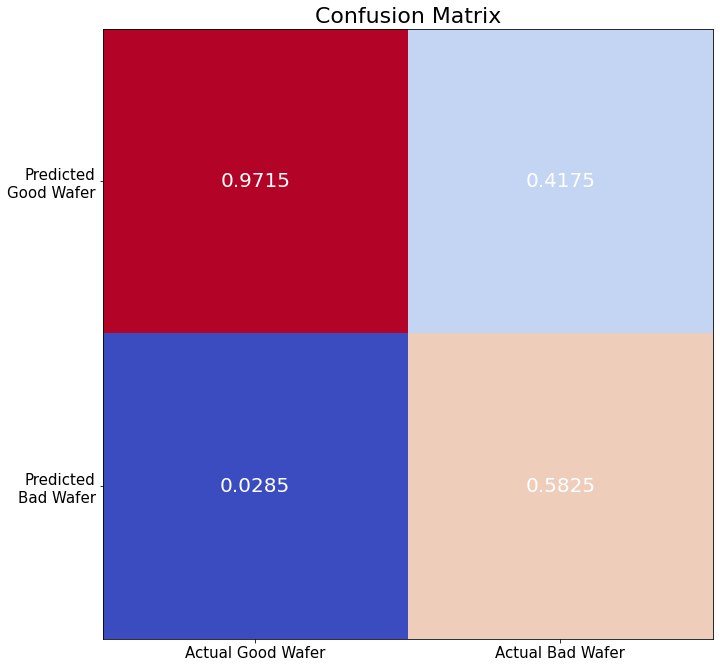

In [22]:
print(f"Threshold Range: {threshold_lower} to {threshold_upper}")

# Classify each latent value
def classify(np_arr, low_threshold, up_threshold):
    good_elems = np.sum((np_arr >= low_threshold) & (np_arr <= up_threshold))
    return good_elems, len(np_arr)-good_elems

good_wafer_good_detection, good_wafer_bad_detection = classify(latent_predicted_good_wafer_data, threshold_lower, threshold_upper)
bad_wafer_good_detection, bad_wafer_bad_detection = classify(latent_predicted_bad_wafer_data, threshold_lower, threshold_upper)

total_bad_testing_data = len(latent_predicted_bad_wafer_data)
total_good_testing_data = len(latent_predicted_good_wafer_data)

table = np.array([
    ["",    "Actual Good Wafer", "Actual Bad Wafer"],
    ["Predicted Good Wafer", good_wafer_good_detection, bad_wafer_good_detection],
    ["Predicted Bad Wafer", good_wafer_bad_detection, bad_wafer_bad_detection]
])

# Display the table
print("\nConfusion Matrix:")
print("{:<40} {:<20} {:<20}".format(*table[0]))  # Header row
for row in table[1:]:
    print("{:<40} {:<20} {:<20}".format(*row))  # Data rows

confusion_matrix = np.array([
    [np.round(good_wafer_good_detection/total_good_testing_data,4), np.round(bad_wafer_good_detection/total_bad_testing_data,4)],  # Predicted Good: Actual Good, Actual Bad
    [np.round(good_wafer_bad_detection/total_good_testing_data,4), np.round(bad_wafer_bad_detection/total_bad_testing_data,4)]   # Predicted Bad: Actual Good, Actual Bad
])

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(confusion_matrix, cmap="coolwarm")

# Adding labels
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(["Actual Good Wafer", "Actual Bad Wafer"], fontsize=15)
ax.set_yticklabels(["Predicted\nGood Wafer", "Predicted\nBad Wafer"], fontsize=15)

# Rotating tick labels for better readability
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Adding text annotations with text wrapping
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(confusion_matrix[i, j]), ha="center", va="center", color="white", fontsize=20)

# Title and display
ax.set_title("Confusion Matrix", fontsize=22)
plt.tight_layout()
plt.show()